In [5]:
# from datasets import load_dataset

# dataset = load_dataset("allenai/ai2_arc", "ARC-Easy")
# dataset["train"][0]

{'id': 'Mercury_7220990',
 'question': 'Which factor will most likely cause a person to develop a fever?',
 'choices': {'text': ['a leg muscle relaxing after exercise',
   'a bacterial population in the bloodstream',
   'several viral particles on the skin',
   'carbohydrates being digested in the stomach'],
  'label': ['A', 'B', 'C', 'D']},
 'answerKey': 'B'}

In [7]:
# # print names of files in directory "LogicBench/LogicBench(Eval)"
# import os
# path = "LogicBench/LogicBench(Eval)"
# files = os.listdir(path)
# files


['BQA', 'MCQA', 'Readme.md']

[('step0', 0.24326599326599327), ('step0', 0.24326599326599327), ('step0', 0.24326599326599327), ('step0', 0.24326599326599327), ('step0', 0.24326599326599327), ('step1', 0.24326599326599327), ('step2', 0.24326599326599327), ('step4', 0.24368686868686867), ('step8', 0.24537037037037038), ('step16', 0.24284511784511784), ('step32', 0.2542087542087542), ('step64', 0.25042087542087543), ('step128', 0.2537878787878788), ('step256', 0.2668350168350168), ('step512', 0.2718855218855219), ('step1000', 0.2748316498316498), ('step2000', 0.29924242424242425), ('step3000', 0.30387205387205385), ('step4000', 0.3143939393939394), ('step5000', 0.3228114478114478), ('step6000', 0.3148148148148148), ('step7000', 0.31776094276094274)]
[('step0', 0.24326599326599327), ('step1', 0.24326599326599327), ('step2', 0.24326599326599327), ('step4', 0.24368686868686867), ('step8', 0.24537037037037038), ('step16', 0.24284511784511784), ('step32', 0.2542087542087542), ('step64', 0.25042087542087543), ('step128', 0.

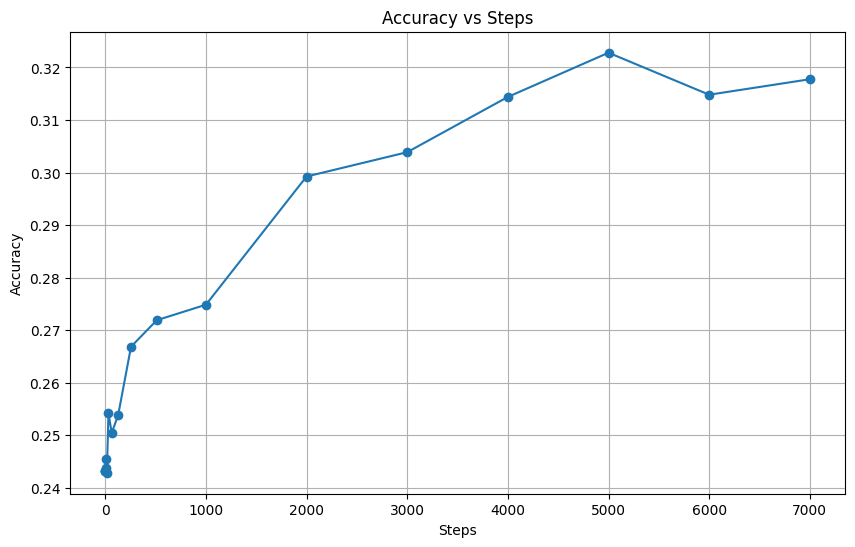

In [9]:
import os
import json

# Directory containing the JSON files
directory = "output/pythia_arc/EleutherAI__pythia-14m"

# List all files in the directory
files = os.listdir(directory)

# Filter out only JSON files
json_files = [file for file in files if file.endswith('.json')]

scores = []
steps = []

for json_file in json_files:
    with open(os.path.join(directory, json_file), 'r') as f:
        data = json.load(f)
        step = data["config"]["model_revision"]
        steps.append(step)
        accuracy = data["results"]["arc_easy"]["acc,none"]
        scores.append(accuracy)
sorted_steps_scores = sorted(zip(steps, scores), key=lambda x: int(x[0][4:]))
print(sorted_steps_scores)
# Deduplicate steps and scores
unique_steps_scores = {}
for step, score in sorted_steps_scores:
    if step not in unique_steps_scores:
        unique_steps_scores[step] = score

# Convert back to sorted list of tuples
deduplicated_sorted_steps_scores = sorted(unique_steps_scores.items(), key=lambda x: int(x[0][4:]))
print(deduplicated_sorted_steps_scores)

import matplotlib.pyplot as plt

# Extract steps and scores for plotting
steps = [int(step[4:]) for step, score in deduplicated_sorted_steps_scores]
scores = [score for step, score in deduplicated_sorted_steps_scores]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(steps, scores, marker='o')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Steps')
plt.grid(True)

# Save the plot to a PDF file
plt.savefig('accuracy_vs_steps.pdf')
plt.show()

In [1]:
# system imports
import time
import json
import itertools
import random

# external imports
from transformers import GPTNeoXForCausalLM, AutoModelForCausalLM, AutoTokenizer, OlmoForCausalLM
import torch
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tuned_lens.nn.lenses import TunedLens, LogitLens
from tuned_lens import TunedLens
from tuned_lens.plotting import PredictionTrajectory
import ipywidgets as widgets
from plotly import graph_objects as go

# local imports
# from src.pythia_intermediate_decoder import PythiaIntermediateDecoder
# from src.olmo_intermediate_decoder import OlmoIntermediateDecoder

# enivornment setup
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.mps.manual_seed(42)

# -------------------------Start of Script------------------------- #
# attempt to auto recognize the device!
device = "cpu"
if torch.cuda.is_available(): 
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): 
    device = "mps"
print(f"using device {device}")


# model_id = 'gpt2-large'
# model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
model_id = "allenai/OLMo-1B-0724-hf"
# model_id = "EleutherAI/pythia-1.4b-deduped"
if "llama" not in model_id: cache_dir = "./models/" + model_id
# To try a diffrent modle / lens check if the lens is avalible then modify this code
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    cache_dir=cache_dir,
    device_map=device,
    output_attentions=True,
    )
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_id,
    cache_dir=cache_dir,
    )

using device mps


/opt/homebrew/Caskroom/miniconda/base/envs/pythia_trials/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
from bertviz import model_view
from transformers import utils
utils.logging.set_verbosity_error()  # Suppress standard warnings

question = "13+4"
prompt = f"Question: What is {question}? Answer: {question}="
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)  # Tokenize input text
outputs = model(input_ids)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])  # Convert input ids to token strings
model_view(attention, tokens, include_layers=list(range(0,16)))  # Display model view

<IPython.core.display.Javascript object>

In [19]:
output_ids = model.generate(input_ids,
               max_new_tokens=10,
               do_sample=False).squeeze()
print(output_ids)
print(len(input_ids.squeeze()))
tokenizer.decode(output_ids[len(input_ids.squeeze()):])

tensor([23433,    27,  1737,   310,  2145,    12,    21,    32, 37741,    27,
         2145,    12,    21,    30,  1166,   187, 32869,    27,   187,  4374,
        50279], device='mps:0')
14


'Question: What is 13+4? Answer: 13+4=17\nAnswer:\nYes<|endoftext|>'